# 단어 임베딩(Word2Vec)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Input, Dense
from keras.models import Model

## 데이터 불러오기

In [2]:
corpus = ['king is a strong man', 
          'queen is a wise woman', 
          'boy is a young man',
          'girl is a young woman',
          'prince is a young king',
          'princess is a young queen',
          'man is strong', 
          'woman is pretty',
          'prince is a boy will be king',
          'princess is a girl will be queen']

## 불용어 제거하기

In [3]:
def remove_stop_words(corpus):
    stop_words = ['is','a','will','be']
    results = []
    
    for text in corpus:
        tmp = text.split(' ')

        for stop_word in stop_words:
            if stop_word in tmp:
                tmp.remove(stop_word)
        
        results.append(' '.join(tmp))
    
    return results

corpus = remove_stop_words(corpus)

In [4]:
for text in corpus:
    print(text)

king strong man
queen wise woman
boy young man
girl young woman
prince young king
princess young queen
man strong
woman pretty
prince boy king
princess girl queen


In [5]:
words = []

for text in corpus:
    for word in text.split(' '):
        words.append(word)

# 중복된 단어 제거
words = set(words)
# 데이터에 존재하는 단어들 확인
words

{'boy',
 'girl',
 'king',
 'man',
 'pretty',
 'prince',
 'princess',
 'queen',
 'strong',
 'wise',
 'woman',
 'young'}

## 단어별 인덱스 매핑 테이블 만들기

In [6]:
word2int = {}

for i, word in enumerate(words):
    word2int[word] = i

In [7]:
word2int

{'strong': 0,
 'girl': 1,
 'woman': 2,
 'king': 3,
 'pretty': 4,
 'boy': 5,
 'young': 6,
 'prince': 7,
 'queen': 8,
 'wise': 9,
 'princess': 10,
 'man': 11}

## 레이블 생성

In [8]:
sentences = []

for sentence in corpus:
    sentences.append(sentence.split())

    
WINDOW_SIZE = 2
data = []

for sentence in sentences:
    # [king, strong, man]
    # [queen, wise, woman]
    for idx, word in enumerate(sentence):
        # 0 , king    1 , strong    2 , man
        # 0 , queen   1 , wise      2 , woman
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0) : min(idx + WINDOW_SIZE, len(sentence)) + 1] :
            # 첫번째 sentence[0 : 3]
            # 두번째 sentence[0 : 4]
            if neighbor != word:
                data.append([word, neighbor])

In [9]:
df = pd.DataFrame(data, columns = ['input', 'label'])
df.head(10)

,input,label
0,king,strong
1,king,man
2,strong,king
3,strong,man
4,man,king
5,man,strong
6,queen,wise
7,queen,woman
8,wise,queen
9,wise,woman


## 모델 생성

In [12]:
ONE_HOT_DIM = len(words)

# 숫자를 원 핫 인코딩으로 전환
def to_one_hot_encoding(data_point_index):
    one_hot_encoding = np.zeros(ONE_HOT_DIM)
    one_hot_encoding[data_point_index] = 1
    return one_hot_encoding

X = [] # 입력 단어
Y = [] # 출력 단어

for x, y in zip(df['input'], df['label']):
    X.append(to_one_hot_encoding(word2int[x]))
    Y.append(to_one_hot_encoding(word2int[y]))
    

# 구조적으로 보면 array와 asarray는 동일하다. 
# 다만, array의 경우 copy=True가 기본값이지만, asarray의 경우 copy=False가 기본값이다. 
# array를 다른 변수에 할당하고 원본을 변경할 경우 array의 copy본은 변경되지 않는다. 
# 그러나 asarray의 경우에는 원본이 변경될 경우 asarray의 복사본까지 변경된다. 

# 학습 데이터를 저장합니다.
X_train = np.asarray(X)
Y_train = np.asarray(Y)

# 시각화를 위해 2차원으로 인코딩합니다.
encoding_dim = 2

# 입력값은 원 핫 인코딩. 단어의 개수만큼 차원을 가진 벡터임.
input_word = Input(shape=(ONE_HOT_DIM,))
# 가중치를 그대로 word2vec으로 사용하기 위해 편향값을 주지 않는다.
encoded = Dense(encoding_dim, use_bias=False)(input_word)
# 디코더는 전달된 값을 원 핫 인코딩으로 전환함.
decoded = Dense(ONE_HOT_DIM, activation='softmax')(encoded)

# word2vec 모델을 지정합니다.
w2v_model = Model(input_word, decoded)

# 크로스 엔트로피를 손실함수로 쓰고, 아담 옵티마이저로 최적화하도록 설정합니다.
w2v_model.compile(optimizer='adam', loss='categorical_crossentropy')

In [13]:
w2v_model.fit(X_train, Y_train, epochs=1000, shuffle=True, verbose=0)

2023-11-05 13:26:13.614372: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-11-05 13:26:13.750522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [51]:
vectors = w2v_model.layers[1].weights[0].numpy().tolist()

w2v_df = pd.DataFrame(vectors, columns = ['x1', 'x2'])
w2v_df['word'] = list(words)
w2v_df = w2v_df[['word', 'x1', 'x2']]
w2v_df

,word,x1,x2
0,strong,-1.390459,1.662327
1,girl,0.542645,-1.419066
2,woman,0.831199,-1.194260
3,king,-0.573648,0.756469
4,pretty,1.805646,0.735879
5,boy,-0.804879,0.594656
6,young,0.148928,0.417152
7,prince,-1.315049,-0.180377
8,queen,0.389506,-1.965547
9,wise,1.328453,0.244359


## word2vec 2차원 공간에 시각화

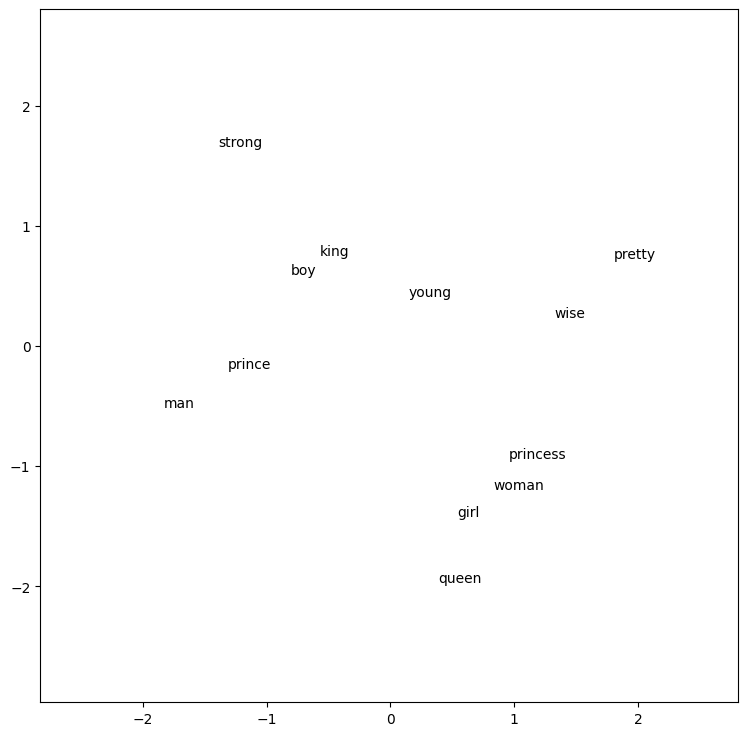

In [68]:
fig, ax = plt.subplots()

for word, x1, x2 in zip(w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
    # 주석 달기(내용, 좌표)
    ax.annotate(word, (x1,x2 ))
    
PADDING = 1.0
# amax 함수는 행렬 (matrix) 에서 행이나 열 각각에 대한 최댓값을 반환 ,axis=0 은 행
x_axis_min = np.amin(vectors, axis=0)[0] - PADDING
y_axis_min = np.amin(vectors, axis=0)[1] - PADDING
x_axis_max = np.amax(vectors, axis=0)[0] + PADDING
y_axis_max = np.amax(vectors, axis=0)[1] + PADDING

# plt 범위
plt.xlim(x_axis_min, x_axis_max)
plt.ylim(y_axis_min, x_axis_max)

# plt 사이즈
plt.rcParams["figure.figsize"] = (9,9)

plt.show()